# Predicting Movie Genres Based on Posters



## Abstract

This project explores a machine learning method of convolutional neural networks (CNN) to predict movie genres based on posters. In this multi-lable classification problem, we collect dataset of 8000 posters, build and tain baseline_CNN model, further modify the CNN model by adding batch normalization and dropout layers to obtain a better performance. As for demonstrating initiatives, we (1) create our own web scraper to acquire dataset, (2) overwrite `my_Data_Set.__getitem__()` and `my_Data_Set.__len__()` methods in `my_Data_Set` class to load data with one-hot labels, (3) mainly use two kinds of methods to select image classifications: `calculate_accuracy_mode_two` and `topk_hit_ratio`. In conclusion, this experiments show that modified CNN model achieves a significant improvement and attains a top 3 hit ratio of 55%.



## 1. Data pre-processing

We utilize api from provided by The Movie Database (TMDB) to achieve the statistic information of movies(e.g.names, genres, overviews, the urls of posters). Then we use 'requests' library to scrape poster pictures from IMDB website based on the urls provided by TMDB API.

build our own web scraper to extract movie images and corresponding lable of genres from The Movie Database (TMDB). This scraper is described in another jupyter notebook (named as *data_acquisition.ipynb*).

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')

os.chdir('/content/drive/My Drive/movie_images')

Mounted at /content/drive


We generate a dictionary mapping indices (from 0 to 18) to 19 kinds of genres,

In [ ]:
gs = [28,12,16,35,80,99,18,10751,14,36,27,10402,9648,10749,878,10770,53,10752,37]
dic = {}
for num, i in enumerate(gs):
  dic[num] = i
id_genre_list = [{"id":28,"name":"Action"},{"id":12,"name":"Adventure"},{"id":16,"name":"Animation"},{"id":35,"name":"Comedy"},{"id":80,"name":"Crime"},{"id":99,"name":"Documentary"},{"id":18,"name":"Drama"},{"id":10751,"name":"Family"},{"id":14,"name":"Fantasy"},{"id":36,"name":"History"},{"id":27,"name":"Horror"},{"id":10402,"name":"Music"},{"id":9648,"name":"Mystery"},{"id":10749,"name":"Romance"},{"id":878,"name":"Science Fiction"},{"id":10770,"name":"TV Movie"},{"id":53,"name":"Thriller"},{"id":10752,"name":"War"},{"id":37,"name":"Western"}]
for k,v in dic.items():
  for item in id_genre_list:
    if item['id'] == v:
      dic[k] = item['name']
dic

{0: 'Action',
 1: 'Adventure',
 2: 'Animation',
 3: 'Comedy',
 4: 'Crime',
 5: 'Documentary',
 6: 'Drama',
 7: 'Family',
 8: 'Fantasy',
 9: 'History',
 10: 'Horror',
 11: 'Music',
 12: 'Mystery',
 13: 'Romance',
 14: 'Science Fiction',
 15: 'TV Movie',
 16: 'Thriller',
 17: 'War',
 18: 'Western'}

We build a training set with 8000 images and encode one-hot lable for each image using a vector of shape 1x19 to represent the genres of a image, where 0 means not belonging and 1 means belonging.

In [ ]:
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm

dic1 = {}

for num, i in enumerate(gs):
  dic1[str(i)] = num

df = pd.read_csv('movie_details.csv')

f=open("train_label.txt","a") # using append mode, parameter changed from "w" to "a"
f1 = open("test_label.txt","a")
for num,row in tqdm(df.iterrows()):
  if os.path.exists(f'dataset/{row["id"]}.jpg'):
    label = np.zeros(19)
    try:
      genre = [dic1[i] for i in row['genre_ids'].strip('[]').split(', ')]
    except Exception:
      continue
    for n in genre:
      label[n] = 1

    if num <= 8000:
      f.write(f'{row["id"]}.jpg ')
      for i in range(19):
        if i == 18:
          f.write("{}\n".format(int(label[i])))
        else:
          f.write("{} ".format(int(label[i])))
    else:
      f1.write(f'{row["id"]}.jpg ')
      for i in range(19):
        if i == 18:
          f1.write("{}\n".format(int(label[i])))
        else:
          f1.write("{} ".format(int(label[i])))
f.close()
f1.close()



We pre-process image data as follows:

1. For training images:
  - resize images to 512*512
  - randomly crop a 400*300 image
  - randomly horizontal flip
  - transform to tensor
  - normalize color channels

2. For testing images:
  - resize images to 512*512
  - centrally crop a 400*300 picture
  - transform to tensor (no need to flip)
  - normalize color channels

3. Data loading
  - using `PIL.Image` to read images according to their pathes, and convert to RGB mode
  - overwrite `my_Data_Set.__getitem__()` and `my_Data_Set.__len__()` methods to load one-hot lables
  - generate `train_DataLoader` and `var_DataLoader`

In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms, utils
import time
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import classification_report, accuracy_score
import pickle
%matplotlib inline

# define data processing
data_transforms = {
    'train': transforms.Compose([
        # resize image to 512*512
        transforms.Resize(512),
        # from a 512*512 image randomly crop a new 400*300 image for training
        transforms.RandomResizedCrop((400,300)),
        # randomly horizontal flip
        transforms.RandomHorizontalFlip(),
        # convert to tensor
        transforms.ToTensor(),
        # normalization
        # [0.485, 0.456, 0.406]，RGB channels' mean and standard deviation
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # for testing set, adopt centerally crop
    'val': transforms.Compose([
        transforms.Resize(512),
        transforms.CenterCrop((400,300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# define data loading
def Load_Image_Information(path):
    # folder path of image
    image_Root_Dir = r'./dataset'
    # obtain image path
    image_Dir = os.path.join(image_Root_Dir, path)
    # open image in RGB mode
    # Pytorch DataLoader using PIL.Image
    # recommend to load data in this way，convert('RGB') to convert gray scale pic
    return Image.open(image_Dir).convert('RGB')


# define my_Dara_Set class
class my_Data_Set(nn.Module):
    def __init__(self, txt, transform=None, target_transform=None, loader=None):
        super(my_Data_Set, self).__init__()
        # open a .txt file to store image id and label
        fp = open(txt, 'r')
        images = []
        labels = []
        # store image id and label
        n=0
        for line in fp:
            if n>=100:
              break
            n+=1
            line.strip('\n')
            line.rstrip()
            information = line.split()
            images.append(information[0])
            labels.append([float(l) for l in information[1:len(information)]])
        self.images = images
        self.labels = labels
        self.transform = transform
        self.target_transform = target_transform
        self.loader = loader

    # overwrite this method to load data
    def __getitem__(self, item):
        # obtain id and label
        imageName = self.images[item]
        label = torch.tensor(self.labels[item])
        # load image data
        image = self.loader(imageName)
        # precess image data
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    # overwrite this method to count the amount of data
    def __len__(self):
        return len(self.images)


# generate DataLoader data input format requred by Pytorch
train_Data = my_Data_Set('train_label.txt', transform=data_transforms['train'], loader=Load_Image_Information)
val_Data = my_Data_Set('test_label.txt', transform=data_transforms['val'], loader=Load_Image_Information)
train_DataLoader = DataLoader(train_Data, batch_size=32, shuffle=True)
val_DataLoader = DataLoader(val_Data, batch_size=32)



Here is an example of the content from `train_DataLoader`, showing 4 images and their genres.

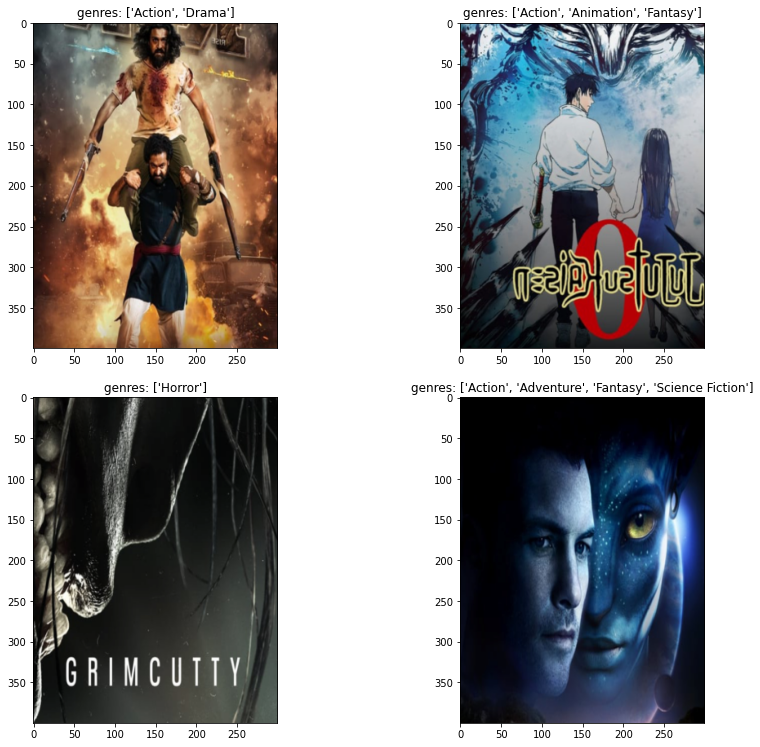

In [ ]:
for images, labels in train_DataLoader:
    plt.cla()
    for i in range(4):
        # [C, H, W] -> [H, W, C]
        img = images[i].numpy().transpose(1, 2, 0)
        # denormalize
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        plt.subplot(2, 2, i + 1)
        genre_idxs = [i for i,x in enumerate(labels[i].tolist()) if x == 1 ]
        genres = [dic[i] for i in genre_idxs]
        plt.title('genres: '+str(genres))
        plt.imshow(img.astype('uint8'))
    plt.tight_layout() # adjust margin
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)
    plt.gcf().set_size_inches(16, 12)
    plt.show()
    break


## 2. Defining the model

Firstly, we define a baseline CNN model as follows.



In [ ]:
class CNN_baseline(torch.nn.Module):

    def __init__(self):
        super(CNN_baseline, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5))
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5))
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5))
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5))
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2))
        self.fc = torch.nn.Linear(64 * 15 * 21, 19)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)  

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.pool4(x)

        x = x.view(-1, 64 * 15 * 21)
        x = self.fc(x)

        return x

Then we modify the architecture of the CNN model by adding: 
  - Dropout layers, which can prevent overfitting on the training data by nullifying the contribution of some neurons towards the next layer and leaves unmodified all others, to prevent overfitting on the training data
  - BatchNorm, which is a normalization technique done between the layers of  mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier.

In [ ]:
class GenreCNN(torch.nn.Module):

    def __init__(self):
        super(GenreCNN, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(5,5))
        self.conv1_bn=nn.BatchNorm2d(16)
        nn.init.xavier_uniform_(self.conv1.weight)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop1 = nn.Dropout2d(p=0.25)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(5,5))
        self.conv2_bn=nn.BatchNorm2d(32)
        nn.init.xavier_uniform_(self.conv2.weight)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop2 = nn.Dropout2d(p=0.25)

        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(5,5))
        self.conv3_bn=nn.BatchNorm2d(64)
        nn.init.xavier_uniform_(self.conv3.weight)
        self.pool3 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop3 = nn.Dropout2d(p=0.25)

        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(5,5))
        self.conv4_bn=nn.BatchNorm2d(64)
        nn.init.xavier_uniform_(self.conv4.weight)
        self.pool4 = nn.MaxPool2d(kernel_size=(2,2))
        self.drop4 = nn.Dropout2d(p=0.25)

        self.fc1 = torch.nn.Linear(64 * 15 * 21, 128)
        self.fc1_bn=nn.BatchNorm1d(128)
        nn.init.xavier_uniform_(self.fc1.weight)
        self.drop5 = nn.Dropout(p=0.5)

        self.fc2 = torch.nn.Linear(128, 64)
        self.fc2_bn=nn.BatchNorm1d(64)
        nn.init.xavier_uniform_(self.fc2.weight)
        self.drop6 = nn.Dropout(p=0.5)

        self.fc3 = torch.nn.Linear(64, 19)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.conv1_bn(x))
        x = self.pool1(x)
        x = self.drop1(x)

        x = self.conv2(x)
        x = F.relu(self.conv2_bn(x))
        x = self.pool2(x)  
        x = self.drop2(x)             

        x = self.conv3(x)
        x = F.relu(self.conv3_bn(x))
        x = self.pool3(x)
        x = self.drop3(x)

        x = self.conv4(x)
        x = F.relu(self.conv4_bn(x))
        x = self.pool4(x)
        x = self.drop4(x) 

        x = x.view(-1, 64 * 15 * 21)
        x = self.fc1(x)
        x = F.relu(self.fc1_bn(x))
        x = self.drop5(x) 
        x = self.fc2(x)
        x = F.relu(self.fc2_bn(x))
        x = self.drop6(x) 
        x = self.fc3(x)

        return x

In this multi-lable classification problem, we define 3 kinds of methods to measure model preformance:
  - `calculate_accuracy_mode_one`: Set a threshold `accuracy_th`. If the predicted possibility `model_pred` is larger than `accuracy_th`, treat it as a instance under this category.
  - `calculate_accuracy_mode_two`: 
  - `topk_hit_ratio` Select the top k-th possibilities as its categories.

We mainly use `calculate_accuracy_mode_two` and `topk_hit_ratio` in the following experiment, especially the latter one.

In [ ]:
# define 3 kinds of methods

# No.1
# Set a threshold accuracy_th. If the predicted possibility model_pred is larger than accuracy_th, treat this image as an instance in this category.
def calculate_accuracy_mode_one(model_pred, labels):
    # notice that "model_pred" is after sigmoid()
    # when model_pred > accuracy_th, set pred_result True
    accuracy_th = 0.3
    pred_result = model_pred > accuracy_th
    pred_result = pred_result.float()
    pred_one_num = torch.sum(pred_result)
    if pred_one_num == 0:
        return 0, 0
    target_one_num = torch.sum(labels)
    true_predict_num = torch.sum(pred_result * labels)
    # precision: the fraction of relevant instances among the retrieved instances
    precision = true_predict_num / pred_one_num
    # recall: the fraction of relevant instances that were retrieved
    recall = true_predict_num / target_one_num
 
    return precision.item(), recall.item()
 
# No.2
# select the top k "precision + recall" label as model prediction results
def calculate_accuracy_mode_two(model_pred, labels,k):
    precision = 0
    recall = 0
    top = k
    # sort prediction results according to their possibilities in descending order, choose the k-th largest results
    pred_label_locate = torch.argsort(model_pred, descending=True)[:, 0:top]
    for i in range(model_pred.shape[0]):
        temp_label = torch.zeros(1, model_pred.shape[1])
        temp_label[0,pred_label_locate[i]] = 1
        target_one_num = torch.sum(labels[i])
        true_predict_num = torch.sum(temp_label * labels[i])
        # calculate "precision" for each image
        precision += true_predict_num / top
        # calculate "recall" for each image
        recall += true_predict_num / target_one_num
    precision = precision/model_pred.shape[0]
    recall = recall/model_pred.shape[0]
    return precision, recall

# No.3
# select top k-th results as model prediction results
def topk_hit_ratio(model_pred, labels, k):
    hit_cnt = 0
    top = k
    # sort prediction results according to their possibilities in descending order, choose the k-th largest results
    pred_label_locate = torch.argsort(model_pred, descending=True)[:, 0:top]
    for i in range(model_pred.shape[0]):
        temp_label = torch.zeros(1, model_pred.shape[1])
        temp_label[0,pred_label_locate[i]] = 1
        target_one_num = torch.sum(labels[i])

        true_predict_num = torch.sum(temp_label * labels[i])
        if true_predict_num > 0:
          hit_cnt += 1

    hit_ratio = hit_cnt/model_pred.shape[0]
    return hit_ratio


## 3. Training the model

At the beginning, we check whether there is a CUDA capable GPU to speed up the training.

Then we define the hyper-parameters such as `num_epochs = 60` and initial `lr = 0.005`, choose `nn.BCELoss()` as `criterion` and `torch.optim.Adam()` as `optimizer`. Additionally, we use `exp_lr_scheduler` to update learning rate every 5 epochs.


In [ ]:
# Train CNN_baseline
# check GPU available
use_gpu = torch.cuda.is_available()
print(use_gpu)
dataloaders = {'train':train_DataLoader, 'test':val_DataLoader}
# read the size of dataset
dataset_sizes = {'train': train_Data.__len__(), 'test': val_Data.__len__()}
 
# topk
k=3
max_hr = 0

plot_result = {'train':[],'test':[]}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    Sigmoid_fun = nn.Sigmoid()
    since = time.time()
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        # in every epoch, check the network model
        for phase in ['train', 'test']:
            running_loss = 0.0
            running_precision = 0.0
            running_recall = 0.0
            running_hr1 = 0.0
            running_hr2 = 0.0
            running_hr3 = 0.0

            batch_num = 0
 
            if phase == 'train':
                # update leanrning rate
                scheduler.step()
                
                model.train()
 
                # train or test images in sequence
                for data in dataloaders[phase]:
                    # obtain input
                    inputs, labels = data
                    # check GPU available
                    if use_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()
 
                    # clear gradient
                    optimizer.zero_grad()
 
                    # forward propagation
                    outputs = model(inputs)
                    # calculate Loss value
                    loss = criterion(Sigmoid_fun(outputs), labels)
 
                    # select a model prediction accuracy based on your requests
                    precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels.cpu(),k)
                    hit_ratio1 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),1)
                    hit_ratio2 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),2)
                    hit_ratio3 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),3)
                    # precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels)
                    running_precision += precision
                    running_recall += recall
                    running_hr1 += hit_ratio1
                    running_hr2 += hit_ratio2
                    running_hr3 += hit_ratio3
                    batch_num += 1
                    # back propagation
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # calculate loss and accuracy after an epoch
                    running_loss += loss.item() * inputs.size(0)
            else:
                
                with torch.no_grad():
                    model.eval()
                    
                    for data in dataloaders[phase]:
                        inputs, labels = data
                        if use_gpu:
                            inputs = inputs.cuda()
                            labels = labels.cuda()

                        outputs = model(inputs)
                        # calculate Loss value
                        # BCELoss inputs: 1. model output should be atfer sigmoid, 2. label should be tensor of float
                        loss = criterion(Sigmoid_fun(outputs), labels)
                        # calculate loss and accuracy after an epoch
                        running_loss += loss.item() * inputs.size(0)
 
                        precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels.cpu(),k)
                        hit_ratio1 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),1)
                        hit_ratio2 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),2)
                        hit_ratio3 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),3)
                        
                        running_hr1 += hit_ratio1
                        running_hr2 += hit_ratio2
                        running_hr3 += hit_ratio3

                        # precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels)
                        running_precision += precision
                        running_recall += recall
                        batch_num += 1
 
            # calculate mean of Loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f} '.format(phase, epoch_loss),end='|')
            epoch_precision = running_precision / batch_num
            print('{} Precision: {:.4f} '.format(phase, epoch_precision),end='|')
            epoch_recall = running_recall / batch_num
            print('{} Recall: {:.4f} '.format(phase, epoch_recall),end='|')
            epoch_hr1 = running_hr1 / batch_num
            epoch_hr2 = running_hr2 / batch_num
            epoch_hr3 = running_hr3 / batch_num

            print('{} hr@k: {:.4f} '.format(phase, epoch_hr1),end=',')
            print('{:.4f} '.format(epoch_hr2),end=',')
            print('{:.4f} '.format(epoch_hr3))

            plot_result[phase].append([epoch_loss,epoch_precision,epoch_recall,epoch_hr1,epoch_hr2,epoch_hr3])
            

            if phase=='test' and epoch_hr3 > max_hr:
                torch.save(model.state_dict(),'base_best_top3hr_model.pkl')

    with open('base_plot_result.pkl','wb') as file:
      pickle.dump(plot_result,file)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
 

 
model = CNN_baseline()
if use_gpu:
    model = model.cuda()

# define loss function
criterion = nn.BCELoss()
params = [{"params": model.parameters(), "lr":0.002}]
optimizer_ft = torch.optim.Adam(params)


# define the scheduler to update lr, every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=30, gamma=0.1)
train_model(model, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=60)

True
Epoch 0/59
----------
train Loss: 0.6963 |train Precision: 0.2422 |train Recall: 0.3165 |train hr@k: 0.4375 ,0.5781 ,0.6328 
test Loss: 0.5962 |test Precision: 0.1849 |test Recall: 0.1987 |test hr@k: 0.2734 ,0.3047 ,0.4531 
Epoch 1/59
----------
train Loss: 0.5009 |train Precision: 0.3099 |train Recall: 0.3871 |train hr@k: 0.4219 ,0.6406 ,0.6719 
test Loss: 0.5300 |test Precision: 0.1458 |test Recall: 0.1600 |test hr@k: 0.2734 ,0.3203 ,0.3594 
Epoch 2/59
----------
train Loss: 0.4209 |train Precision: 0.2448 |train Recall: 0.3546 |train hr@k: 0.3047 ,0.3984 ,0.5000 
test Loss: 0.4039 |test Precision: 0.2292 |test Recall: 0.2561 |test hr@k: 0.3203 ,0.3984 ,0.4688 
Epoch 3/59
----------
train Loss: 0.3800 |train Precision: 0.3229 |train Recall: 0.3822 |train hr@k: 0.3828 ,0.5938 ,0.6719 
test Loss: 0.4063 |test Precision: 0.1562 |test Recall: 0.1732 |test hr@k: 0.3281 ,0.3984 ,0.4141 
Epoch 4/59
----------
train Loss: 0.3675 |train Precision: 0.3177 |train Recall: 0.3283 |train hr@k

In [ ]:
# Train GenreCNN

use_gpu = torch.cuda.is_available()
print(use_gpu)
dataloaders = {'train':train_DataLoader, 'test':val_DataLoader}
# read data size
dataset_sizes = {'train': train_Data.__len__(), 'test': val_Data.__len__()}
 
# top k
k=3
max_hr = 0

plot_result = {'train':[],'test':[]}

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    Sigmoid_fun = nn.Sigmoid()
    since = time.time()
 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
 
        for phase in ['train', 'test']:
            running_loss = 0.0
            running_precision = 0.0
            running_recall = 0.0
            running_hr1 = 0.0
            running_hr2 = 0.0
            running_hr3 = 0.0

            batch_num = 0
 
            if phase == 'train':
                # lr update scheduler
                scheduler.step()
                # train model
                model.train()
 
                for data in dataloaders[phase]:
                    inputs, labels = data
                    if use_gpu:
                        inputs = inputs.cuda()
                        labels = labels.cuda()

                    optimizer.zero_grad()
 
                    # forward propagation
                    outputs = model(inputs)
                    loss = criterion(Sigmoid_fun(outputs), labels)
 
                    # select a model prediction accuracy based on your requests
                    precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels.cpu(),k)
                    hit_ratio1 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),1)
                    hit_ratio2 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),2)
                    hit_ratio3 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),3)
                    # precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels)
                    running_precision += precision
                    running_recall += recall
                    running_hr1 += hit_ratio1
                    running_hr2 += hit_ratio2
                    running_hr3 += hit_ratio3
                    batch_num += 1
                    # backward propagation
                    loss.backward()
                    # update weights
                    optimizer.step()
                    # calculate loss and accuracy after an epoch
                    running_loss += loss.item() * inputs.size(0)
            else:
                with torch.no_grad():
                    model.eval()
                    for data in dataloaders[phase]:
                        inputs, labels = data
                        if use_gpu:
                            inputs = inputs.cuda()
                            labels = labels.cuda()
 
                        # forward propagaton
                        outputs = model(inputs)
                        # calculate Loss value
                        # BCELoss inputs: 1. model output should be atfer sigmoid, 2. label should be tensor of float
                        loss = criterion(Sigmoid_fun(outputs), labels)
                        # calculate loss and accuracy after an epoch
                        running_loss += loss.item() * inputs.size(0)
 
                        # select a model prediction accuracy based on your requests
                        precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels.cpu(),k)
                        hit_ratio1 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),1)
                        hit_ratio2 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),2)
                        hit_ratio3 = topk_hit_ratio(Sigmoid_fun(outputs), labels.cpu(),3)
                        
                        running_hr1 += hit_ratio1
                        running_hr2 += hit_ratio2
                        running_hr3 += hit_ratio3

                        # precision, recall = calculate_accuracy_mode_two(Sigmoid_fun(outputs), labels)
                        running_precision += precision
                        running_recall += recall
                        batch_num += 1
 
            # calculate mean of Loss and accuracy
            epoch_loss = running_loss / dataset_sizes[phase]
            print('{} Loss: {:.4f} '.format(phase, epoch_loss),end='|')
            epoch_precision = running_precision / batch_num
            print('{} Precision: {:.4f} '.format(phase, epoch_precision),end='|')
            epoch_recall = running_recall / batch_num
            print('{} Recall: {:.4f} '.format(phase, epoch_recall),end='|')
            epoch_hr1 = running_hr1 / batch_num
            epoch_hr2 = running_hr2 / batch_num
            epoch_hr3 = running_hr3 / batch_num

            print('{} hr@k: {:.4f} '.format(phase, epoch_hr1),end=',')
            print('{:.4f} '.format(epoch_hr2),end=',')
            print('{:.4f} '.format(epoch_hr3))

            plot_result[phase].append([epoch_loss,epoch_precision,epoch_recall,epoch_hr1,epoch_hr2,epoch_hr3])
            

            if phase=='test' and epoch_hr3 > max_hr:
                torch.save(model.state_dict(),'best_top3hr_model.pkl')

    with open('plot_result.pkl','wb') as file:
      pickle.dump(plot_result,file)
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
 

 
model = GenreCNN()
if use_gpu:
    model = model.cuda()

# define loss function
criterion = nn.BCELoss()
params = [{"params": model.parameters(), "lr":0.006}]
optimizer_ft = torch.optim.Adam(params)


# define the scheduler to update lr, every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)
train_model(model, criterion, optimizer_ft,exp_lr_scheduler, num_epochs=60)

True
Epoch 0/59
----------
train Loss: 0.7360 |train Precision: 0.1745 |train Recall: 0.1870 |train hr@k: 0.2969 ,0.4062 ,0.4766 
test Loss: 20.1294 |test Precision: 0.1380 |test Recall: 0.1796 |test hr@k: 0.0312 ,0.3516 ,0.3828 
Epoch 1/59
----------
train Loss: 0.6246 |train Precision: 0.1302 |train Recall: 0.1368 |train hr@k: 0.1484 ,0.2734 ,0.3359 
test Loss: 1.6688 |test Precision: 0.2318 |test Recall: 0.2844 |test hr@k: 0.2344 ,0.3594 ,0.5469 
Epoch 2/59
----------
train Loss: 0.5216 |train Precision: 0.1589 |train Recall: 0.1842 |train hr@k: 0.1641 ,0.2891 ,0.4062 
test Loss: 1.3859 |test Precision: 0.2031 |test Recall: 0.2383 |test hr@k: 0.1250 ,0.3516 ,0.5312 
Epoch 3/59
----------
train Loss: 0.4616 |train Precision: 0.2005 |train Recall: 0.2311 |train hr@k: 0.2109 ,0.3906 ,0.5000 
test Loss: 1.2019 |test Precision: 0.2734 |test Recall: 0.3339 |test hr@k: 0.1562 ,0.3906 ,0.7031 
Epoch 4/59
----------
train Loss: 0.4333 |train Precision: 0.3125 |train Recall: 0.4206 |train hr@

## 4. Numerical results

### Performance

By printing the results of 60 epochs, we can realize that baseline CNN model and modified Genre_CNN model can obtain:

| performance metrics | baseline_train | baseline_test | GenreCNN_train | GenreCNN_test |
| ----------- | ----------- | ----------- |----------- |----------- |
| loss | 0.34 | 0.40 | 0.36 | 0.39 |
| precision | 0.37 | 0.22 | 0.35 | 0.26 |
| recall | 0.43 | 0.23 | 0.40 | 0.28 |
| top 3 hit ratio | 0.78 | 0.45 | 0.75 | 0.55 |


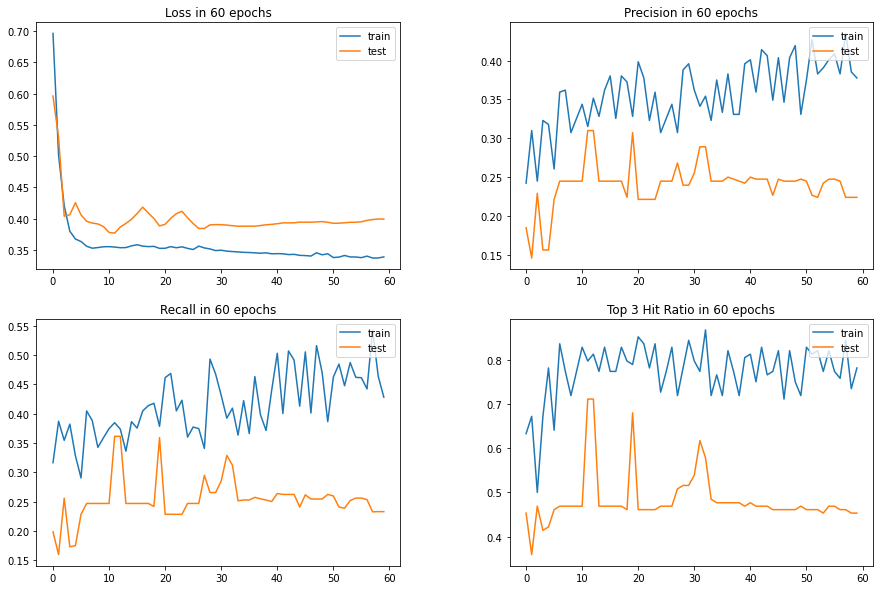

In [ ]:
# baseline result
import pickle
import matplotlib.pyplot as plt
with open('base_plot_result.pkl','rb') as file:
  plot_result = pickle.load(file)
train_result = plot_result['train']
test_result = plot_result['test']

loss_train = [i[0] for i in train_result]
precision_train = [i[1] for i in train_result]
recall_train = [i[2] for i in train_result]
hr_train = [i[5] for i in train_result]

loss_test = [i[0] for i in test_result]
precision_test = [i[1] for i in test_result]
recall_test = [i[2] for i in test_result]
hr_test = [i[5] for i in test_result]

x = range(len(loss_train))
title_list = [f'Loss in {len(loss_train)} epochs',f'Precision in {len(loss_train)} epochs',f'Recall in {len(loss_train)} epochs',f'Top 3 Hit Ratio in {len(loss_train)} epochs']
plt.cla()
for num,i in enumerate([(loss_train,loss_test),(precision_train,precision_test),(recall_train,recall_test),(hr_train,hr_test)]):
  plt.subplot(2,2,num+1)
  # plt.gca().set_color_cycle(['blue', 'yellow'])
  plt.plot(x, i[0])
  plt.plot(x, i[1])
  plt.legend(['train', 'test'], loc='upper right')
  plt.title(title_list[num])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.gcf().set_size_inches(15, 10)
plt.show()

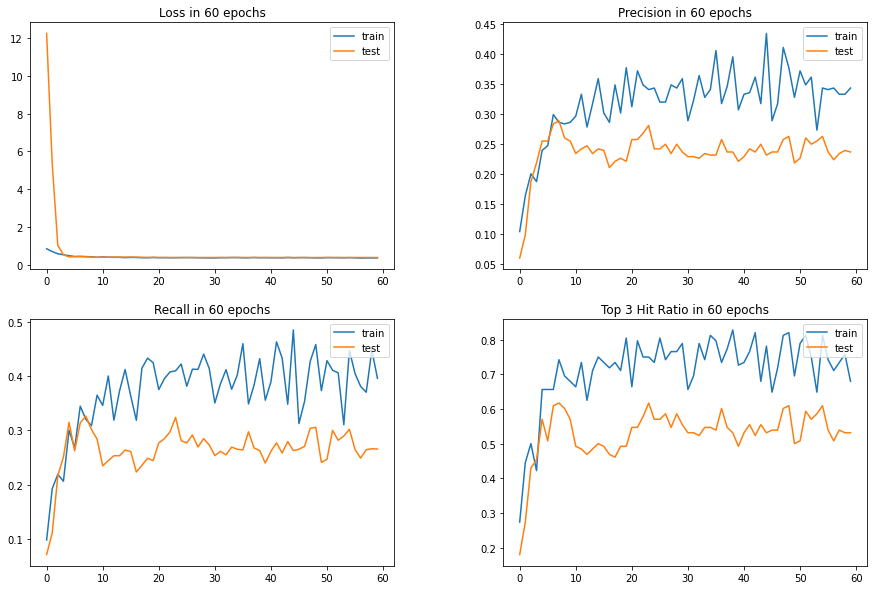

In [ ]:
# GenreCNN result
with open('plot_result.pkl','rb') as file:
  plot_result = pickle.load(file)
train_result = plot_result['train']
test_result = plot_result['test']

loss_train = [i[0] for i in train_result]
precision_train = [i[1] for i in train_result]
recall_train = [i[2] for i in train_result]
hr_train = [i[5] for i in train_result]

loss_test = [i[0] for i in test_result]
precision_test = [i[1] for i in test_result]
recall_test = [i[2] for i in test_result]
hr_test = [i[5] for i in test_result]

x = range(len(loss_train))
title_list = [f'Loss in {len(loss_train)} epochs',f'Precision in {len(loss_train)} epochs',f'Recall in {len(loss_train)} epochs',f'Top 3 Hit Ratio in {len(loss_train)} epochs']
plt.cla()
for num,i in enumerate([(loss_train,loss_test),(precision_train,precision_test),(recall_train,recall_test),(hr_train,hr_test)]):
  plt.subplot(2,2,num+1)
  # plt.gca().set_color_cycle(['blue', 'yellow'])
  plt.plot(x, i[0])
  plt.plot(x, i[1])
  plt.legend(['train', 'test'], loc='upper right')
  plt.title(title_list[num])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.gcf().set_size_inches(15, 10)
plt.show()

### Prediction of a random movie poster

Here is a example as below to indicate the prodiction result of our model.

Given a random poster, we plot its actual `label` array and Genre_CNN `output` array, especially the latter is after `nn.Sigmoid()`. The result shows the top 3 possibility genres that our Genre_CNN model predicts are *Thriller*, *Horror* and *Action*, where its actual genres are *Thriller*, *Adventure* and *Action*.

In this case, predicting this poster as a *Horror* movie also make sense due to its color and syle. Additionally, the real genre *Adventure* gets a high possibility as well. Thus, the results of this model are quite consistent with human's predictions.

True


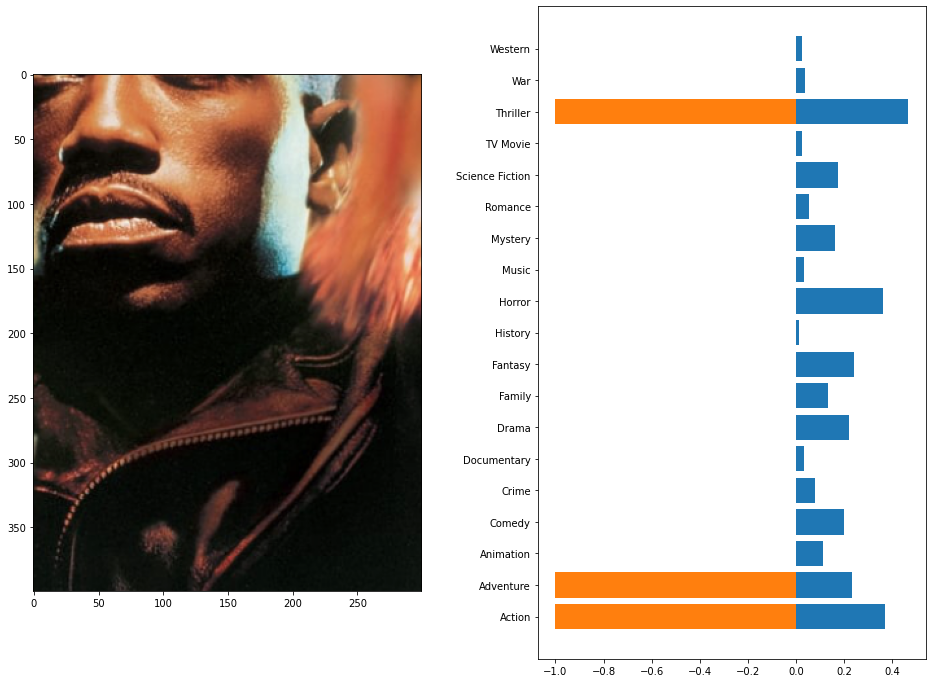

In [ ]:
##test the trained model and show result on a random picture
model = GenreCNN()
use_gpu = torch.cuda.is_available()
print(use_gpu)
Sigmoid_fun = nn.Sigmoid()
if use_gpu:
  model = model.cuda()
model.load_state_dict(torch.load('best_top3hr_model.pkl'))
with torch.no_grad():
    model.eval()
    for data in val_DataLoader:
        inputs, labels = data
        plt.cla()
        # [C, H, W] -> [H, W, C]
        img = inputs[1].numpy().transpose(1, 2, 0)
        # 反Normalize操作
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]) * 255
        plt.subplot(1, 2, 1)
        plt.imshow(img.astype('uint8'))
        
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
        outputs = Sigmoid_fun(model(inputs))
        y_pred = outputs.tolist()[1]
        y = labels.tolist()[1]
        break

plt.subplot(1, 2, 2)
plt.barh(range(19), np.array(y_pred), tick_label = [dic[i] for i in range(19)])
plt.barh(range(19), 0-np.array(y),tick_label = [dic[i] for i in range(19)])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=None)
plt.gcf().set_size_inches(16, 12)
plt.show()